In [1]:
%matplotlib inline

import numpy as np
import collections
from collections import OrderedDict, Counter, defaultdict
import pandas as pd

import Bio
from Bio import SeqIO

import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show 
import matplotlib.patches as patches    
from matplotlib import colors


import glob

import subprocess
from subprocess import call

import re

import pickle

from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

from scipy import stats


from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

/home/alla/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# open metadata with scores and metrics
meta = pd.read_csv('tmp_res/METADATA_CURRENT.txt', sep='\t')

# gencode 25
metadata_pc_g25 = pd.read_csv('tmp_res/metadata_pc_g25.txt', sep='\t')


P_Set = pd.read_csv('tmp_res/SET1.txt', sep='\t')

R_Set = pd.read_csv('tmp_res/SET2.txt', sep='\t')

R_Set['pos_of_codon'] = [int(x.split('; ')[1].split('-')[0])-1 for x in R_Set.Riboseq_Summary.tolist()]

R_Set['codon'] = [x.split('; ')[0] for x in R_Set.Riboseq_Summary.tolist()]

R_Set[0:2]

,tr_id,gene,N_term_start1,N_term_end1,len_codons,global_coo_50_and_less,strand,global_coo_primary,PhyloCSF120score,number_of_records,ovlp,Riboseq_Summary,Coverage_value_ext,Proteomics_count_ext,tag,transcript_type,CDS_ratio,pos_of_codon,codon
0,ENST00000379389.4,ISG15,1,151,50.0,chr1:1013424-1013573,+,chr1:1013424-1013573,-2443.9971,111,0;0;0,ATC; 98-152; Rank: 288; cov: 53.85,53.846154,0.0,"basic,appris_principal_1,CCDS",protein_coding,0.327240,97,ATC
1,ENST00000349431.10,UBE2J2,28,220,64.0,chr1:1273666-1273815,-,chr1:1273666-1273857,-1285.8186,78,0;0;0,ACG; 173-221; Rank: 328; cov: 90.91,90.909091,0.0,"basic,appris_principal_1,CCDS",protein_coding,0.762814,172,ACG


### RiboSet 

In [3]:
li = []

for el in R_Set[['tr_id', 'gene', 'pos_of_codon', 'N_term_start1', 'N_term_end1']].to_numpy():
    tr_id = el[0]
    gene = el[1]
    pred_ext_start = el[2]
    n_term_start = el[3]
    n_term_stop = el[4]
    
    # get sequence of theoretical nte 
    transcript_seq = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].transcript_seq
    nte_seq = transcript_seq[n_term_start:n_term_stop]
    
    # iterate over NTE 
    all_ATG_pos = [_.start() for _ in re.finditer('ATG', nte_seq)] 
    for ATG_pos in all_ATG_pos:
        if ATG_pos % 3 == 0:
            print (gene, tr_id, 'in-frame ATG in theoretical NTE')
        else:
            print (gene, tr_id, 'out-of-frame ATG in theoretical NTE')
            
            li.append([tr_id, gene, nte_seq, ATG_pos])

SMIM12 ENST00000521580.2 out-of-frame ATG in theoretical NTE
BTF3L4 ENST00000313334.12 out-of-frame ATG in theoretical NTE
BTF3L4 ENST00000313334.12 out-of-frame ATG in theoretical NTE
PCSK9 ENST00000302118.5 out-of-frame ATG in theoretical NTE
FAM102B ENST00000370035.7 out-of-frame ATG in theoretical NTE
EPRS ENST00000366923.7 out-of-frame ATG in theoretical NTE
DESI2 ENST00000302550.15 out-of-frame ATG in theoretical NTE
ID2 ENST00000234091.8 out-of-frame ATG in theoretical NTE
ID2 ENST00000234091.8 out-of-frame ATG in theoretical NTE
TXNDC9 ENST00000264255.7 out-of-frame ATG in theoretical NTE
PLEKHB2 ENST00000234115.10 out-of-frame ATG in theoretical NTE
AC013461.1 ENST00000375213.7 out-of-frame ATG in theoretical NTE
PPP4R2 ENST00000356692.9 out-of-frame ATG in theoretical NTE
FSTL1 ENST00000295633.7 out-of-frame ATG in theoretical NTE
MXD4 ENST00000337190.6 in-frame ATG in theoretical NTE
STIM2 ENST00000467087.5 in-frame ATG in theoretical NTE
STIM2 ENST00000467087.5 out-of-frame

In [4]:
out_of_frame_ATGs_Rset_df = pd.DataFrame(li, columns = ['tr_id', 'gene', 'nte_seq', 'ATG_pos'])

print ('# of genes:', out_of_frame_ATGs_Rset_df.gene.nunique(), '# of trs: ', out_of_frame_ATGs_Rset_df.tr_id.nunique())
print ('# of ATGs: ', out_of_frame_ATGs_Rset_df.shape[0])

# of genes: 57 # of trs:  57
# of ATGs:  67


In [5]:
tmp = out_of_frame_ATGs_Rset_df.groupby(by='gene').count().sort_values(by='tr_id', ascending=False)

', '.join(list(tmp[tmp['tr_id'] == 2].index))

'ID2, CARNMT1, DHFR, CCDC8, FBXL3, BTF3L4, NDUFA2, NIP7'

## PhyloSET

In [6]:
P_Set.columns

Index(['tr_id', 'gene', 'N_term_start1', 'N_term_end1', 'len_codons',
       'global_coo_50_and_less', 'strand', 'global_coo_primary',
       'PhyloCSF120score', 'number_of_records', 'ovlp', 'Riboseq_Summary',
       'Coverage_value_ext', 'Proteomics_count_ext', 'tag', 'transcript_type'],
      dtype='object')

In [7]:
li = []

for el in P_Set[['tr_id', 'gene', 'N_term_start1', 'N_term_end1']].to_numpy():
    tr_id = el[0]
    gene = el[1]
    n_term_start = el[2]
    n_term_stop = el[3]
    
    # get sequence of theoretical nte 
    transcript_seq = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].transcript_seq
    nte_seq = transcript_seq[n_term_start:n_term_stop]
    
    # iterate over NTE 
    all_ATG_pos = [_.start() for _ in re.finditer('ATG', nte_seq)] 
    for ATG_pos in all_ATG_pos:
        if ATG_pos % 3 == 0:
            print (gene, tr_id, 'in-frame ATG in theoretical NTE')
        else:
            print (gene, tr_id, 'out-of-frame ATG in theoretical NTE')
            
            li.append([tr_id, gene, nte_seq, ATG_pos])
            
out_of_frame_ATGs_Pset_df = pd.DataFrame(li, columns = ['tr_id', 'gene', 'nte_seq', 'ATG_pos'])

print ('# of genes:', out_of_frame_ATGs_Pset_df.gene.nunique(), '# of trs: ', out_of_frame_ATGs_Pset_df.tr_id.nunique())
print ('# of ATGs: ', out_of_frame_ATGs_Pset_df.shape[0])

TAF12 ENST00000373824.8 out-of-frame ATG in theoretical NTE
OAZ3 ENST00000635322.1 out-of-frame ATG in theoretical NTE
OAZ3 ENST00000627780.2 out-of-frame ATG in theoretical NTE
OAZ3 ENST00000321531.10 out-of-frame ATG in theoretical NTE
NRXN1 ENST00000636345.1 out-of-frame ATG in theoretical NTE
MAP3K19 ENST00000392915.6 out-of-frame ATG in theoretical NTE
ADCY5 ENST00000462833.5 out-of-frame ATG in theoretical NTE
TRPC1 ENST00000476941.5 out-of-frame ATG in theoretical NTE
TRPC1 ENST00000476941.5 out-of-frame ATG in theoretical NTE
TRPC1 ENST00000273482.10 out-of-frame ATG in theoretical NTE
TRPC1 ENST00000273482.10 out-of-frame ATG in theoretical NTE
FBXW7 ENST00000603841.1 out-of-frame ATG in theoretical NTE
MAP3K5 ENST00000359015.4 out-of-frame ATG in theoretical NTE
POMZP3 ENST00000275569.8 out-of-frame ATG in theoretical NTE
POMZP3 ENST00000310842.8 out-of-frame ATG in theoretical NTE
SLC35G5 ENST00000382435.4 out-of-frame ATG in theoretical NTE
PELI2 ENST00000267460.8 out-of-fr

In [8]:
tmp = out_of_frame_ATGs_Pset_df.groupby(by='tr_id').count().sort_values(by='gene', ascending=False).reset_index().merge(out_of_frame_ATGs_Pset_df[['tr_id', 'gene']], on='tr_id', how='inner').drop_duplicates()

tmp[0:10]

,tr_id,gene_x,nte_seq,ATG_pos,gene_y
0,ENST00000373519.1,6,6,6,PABPC1L2A
6,ENST00000373521.3,6,6,6,PABPC1L2B
12,ENST00000621775.1,3,3,3,USP27X
15,ENST00000444995.7,3,3,3,LRP5L
18,ENST00000402859.6,3,3,3,LRP5L
21,ENST00000262158.6,3,3,3,SMAD7
24,ENST00000380861.8,3,3,3,WWC3
27,ENST00000610821.4,3,3,3,LRP5L
30,ENST00000402785.2,3,3,3,LRP5L
33,ENST00000624244.1,3,3,3,AC007906.1


In [9]:
', '.join(tmp[tmp['gene_x'] == 3].gene_y.tolist())

'USP27X, LRP5L, LRP5L, SMAD7, WWC3, LRP5L, LRP5L, AC007906.1'

In [10]:
', '.join(tmp[tmp['gene_x'] == 2].gene_y.tolist())

'TBC1D29, CCDC8, TBC1D29, TBC1D29, TRPC1, TRPC1'

In [11]:
tmp[tmp['gene_x'] == 2].gene_y.nunique()

3

# Let's look at their profiles

In [13]:
def prepare_data_for_trips2(meta, file_counts, metadata_pc_g25, 
                           tr_id, gene, l, p, fraq, cds, 
                           predicted_ext_start=False, figsize=(20, 10),
                           xlims='full', zeros=True, name='test.png', linew=9):
    
    f = pd.read_csv(file_counts)
    f.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq']
    
    atgs_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}
    stop_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}

    for pos in f.Position.tolist():
        codon = ''.join(f.Sequence.tolist()[(pos-1):(pos-1+3)])
        if codon == 'ATG':
            if pos % 3 == 0:
                atgs_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                atgs_pos['frame_1'].append(pos)
            else:
                atgs_pos['frame_2'].append(pos)
            
        elif (codon == 'TGA') | (codon == 'TAA') | (codon == 'TAG'):
            if pos % 3 == 0:
                stop_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                stop_pos['frame_1'].append(pos)
            else:
                stop_pos['frame_2'].append(pos)
        else:
            continue     
            
    # add CDS borders
    cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
    cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos + 1
    cds_start_codon = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_codon
    
    if xlims == 'ext':
        xlim1 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1
        xlim2 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1 + 50*3
    elif len(xlims) == 2:
        xlim1 = xlims[0]
        xlim2 = xlims[1]
    else: # full transcript
        xlim1 = 0
        xlim2 = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    
    d = {}
    
    d['cds_stop_pos'] = cds_stop_pos
    d['cds_start_pos'] = cds_start_pos
    d['cds_start_codon'] = cds_start_codon
    d['f'] = f
    d['stop_pos'] = stop_pos
    d['atgs_pos'] = atgs_pos
    d['xlims'] = (xlim1, xlim2)
    d['predicted_ext_start'] = predicted_ext_start
    d['l'] = l
    d['p'] = p
    d['figsize'] = figsize
    d['fraq'] = fraq
    d['cds'] = cds
    d['name'] = tr_id+'_'+gene
    d['zeros'] = zeros
    d['linew'] = linew
    
    return d


def trips_full2(d, name='test', font1=38, font2=45):
    
    l = d['l']
    p = d['p']
    f = d['f'] # dict with frames 
    atgs_pos = d['atgs_pos']
    stop_pos = d['stop_pos']
    cds_start_pos = d['cds_start_pos']
    cds_stop_pos = d['cds_stop_pos']
    figsize = d['figsize']
    xlims = d['xlims']
    fraq = d['fraq']
    cds = d['cds']
    name = d['name']
    zeros = d['zeros']
    linewidth = d['linew'] 
    
    fig, axes = plt.subplots(5, 1, figsize = figsize, 
                             gridspec_kw={'height_ratios':[10,1.5,1,1,1]}, sharex=True, sharey=False, )

    main_plot = axes[0]
    #cds = axes[1]
    orfs = axes[1]
    red = axes[2]
    green = axes[3]
    blue = axes[4]

    # x 
    main_plot.set_xlim(f.Position.min(), f.Position.max()+1)

    # y
    
    if xlims is not False:
        f1 = f[xlims[0]:xlims[1]]
        max_height = np.max([np.max(f1.Frame1.tolist()), np.max(f1.Frame2.tolist()), np.max(f1.Frame3.tolist())])
        print (max_height)
    else:
        max_height = np.max([np.max(f.Frame1.tolist()), np.max(f.Frame2.tolist()), np.max(f.Frame3.tolist())])
        print (max_height)
        
    #### ????? why they dissappear????? ######    
    main_plot.set_ylim(0, max_height+max_height/l)
    main_plot.set_yticks(np.arange(0, max_height+max_height/l, p))
    main_plot.set_yticklabels(np.arange(0, max_height+max_height/l, p, dtype=np.int64), fontsize=font1)
    
    # print (f[125:150])

    # #frame 1 = red, frame2 = green, frame3 = blue
    if zeros == True:
        main_plot.plot(f.Frame1.tolist(), color = 'coral', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame2.tolist(), color = 'mediumseagreen', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame3.tolist(), color = 'cornflowerblue', linewidth=linewidth, linestyle='-')
    
    else:
        # delete zeros 
        t = f[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = f[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = f[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
        main_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), color = 'coral', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), color = 'mediumseagreen', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), color = 'cornflowerblue', linewidth=linewidth, linestyle='-')
    
        
        
        
    red.set_facecolor('coral')
    green.set_facecolor('mediumseagreen')
    blue.set_facecolor('cornflowerblue')
    #cds.set_facecolor('lightgrey')

    #blue.set_xticks(np.arange(0, f.Position.max(), 50))
    #blue.set_xticklabels(np.arange(0, f.Position.max(), 50), fontsize=45)

    red.set_yticklabels(())
    green.set_yticklabels(())
    blue.set_yticklabels(())
    #cds.set_yticklabels(())
    orfs.set_yticklabels(())
    
    

    blue.set_ylabel('f2', fontsize=font1)#, rotation = 0)
    red.set_ylabel('f0', fontsize=font1)#, rotation = 0)
    green.set_ylabel('f1', fontsize=font1)#, rotation = 0)
    #cds.set_ylabel('cds', fontsize=35)#, rotation = 0)
    orfs.set_ylabel('orf', fontsize=font1)#, rotation = 0)

    for frame, pos_li in atgs_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
            
    for frame, pos_li in stop_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
            
                    
    # add start of annotated CDS
    main_plot.vlines(cds_stop_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    main_plot.vlines(cds_start_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    #main_plot.text(x = cds_stop_pos-100, y = max_height+max_height/10, s = 'cds stop', fontsize=39)
    #main_plot.text(x = cds_start_pos-10, y = max_height+0.1, s = 'cds start', fontsize=39)


    # add rectangle = CDS
    #if cds is True:
        #rect = patches.Rectangle((cds_start_pos, 0),cds_stop_pos-cds_start_pos,
                         #1,linewidth=1,edgecolor='r',facecolor='lightgrey')
        #cds.add_patch(rect)

        # add non-AUG - cds_start_pos
        #cds.text(x = cds_start_pos, y = 0.3, s = 'AUG', fontsize=38)

    
    # add rectangle = extended CDS
    xlims = d['xlims']
    predicted_ext_start = d['predicted_ext_start']
    if xlims is not False:
        if predicted_ext_start is not False:
            Nst = int(predicted_ext_start.split('_')[0])
            codon_name = predicted_ext_start.split('_')[1]
            N2 = cds_stop_pos
            rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            orfs.add_patch(rect)
        
            orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)

    
    blue.set_xticks(range(f.Position.min(), f.Position.max()+1, fraq))       
    blue.set_xticklabels(range(f.Position.min(), f.Position.max()+1, fraq), fontsize=font1)
    
    print (f.Position.min())
    
    
    if xlims is not False:    
        plt.xlim(xlims[0], xlims[1])
        
        
    main_plot.set_title(name, fontsize=font2)
    plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.1)
    
    plt.savefig('plots/'+name+'.png', dpi = 300, bbox_inches = 'tight')
    

In [14]:
out_of_frame_ATGs_Rset_df[out_of_frame_ATGs_Rset_df['gene'] == 'DHRS7']

,tr_id,gene,nte_seq,ATG_pos
41,ENST00000216500.9,DHRS7,ACATTAGACAGGGACCTGAAAGGATCCAGAAATGGGACTTTACATC...,31
42,ENST00000216500.9,DHRS7,ACATTAGACAGGGACCTGAAAGGATCCAGAAATGGGACTTTACATC...,76
43,ENST00000216500.9,DHRS7,ACATTAGACAGGGACCTGAAAGGATCCAGAAATGGGACTTTACATC...,142


ID2, CARNMT1, DHFR, CCDC8, FBXL3, BTF3L4, NDUFA2, NIP7

602
0
5272
0
267
0
493
0
1929
0
1246
0
2064
0
1076
0
1482
0
1419
0
2455
0
7568
0
212
0
3236
0
2639
0
9260
0
2320
0
1126
0
2220
0
3027
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


237
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


643
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


800
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


437
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


168
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


688
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


593
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


2873
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


562
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


6144
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1573
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1467
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


574
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


421
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


2073
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


2443
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


2183
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1227
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1138
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


16448
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


612
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


191
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1013
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


789
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


311
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


2279
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


365
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


567
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1300
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


6917
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1887
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


280
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1034
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


146
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


2996
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


4058
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3896
0


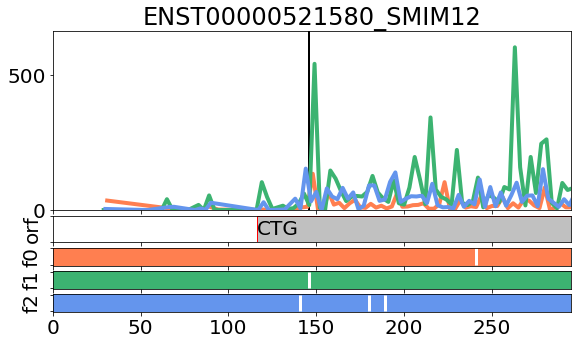

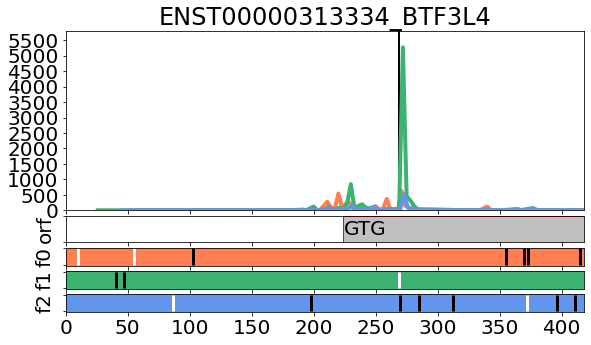

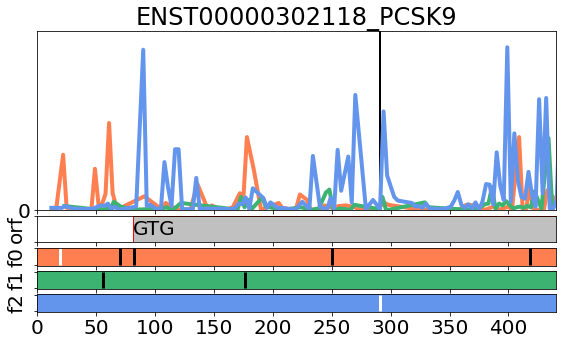

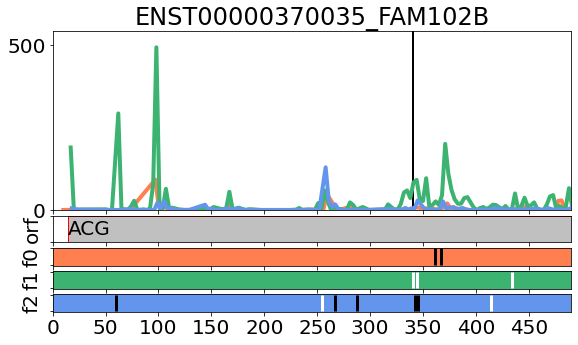

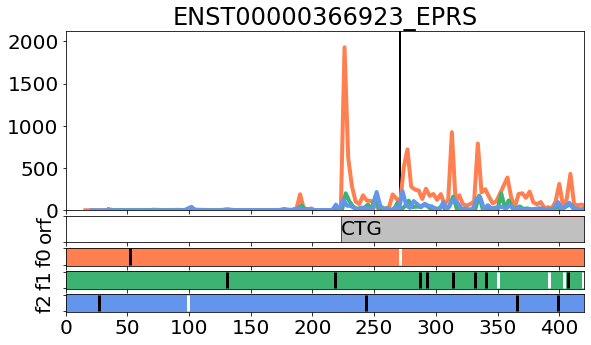

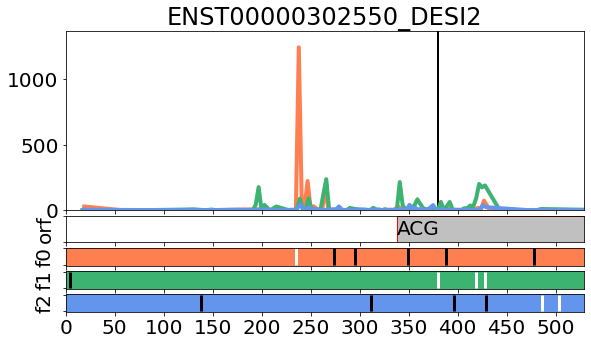

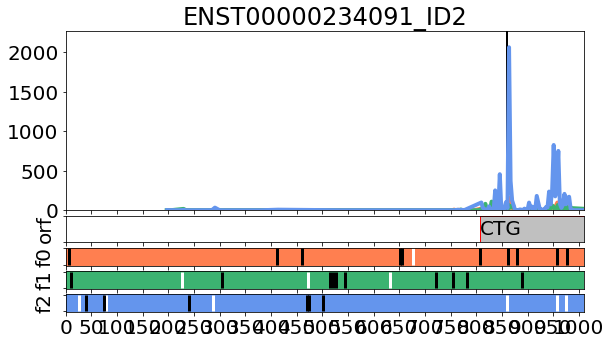

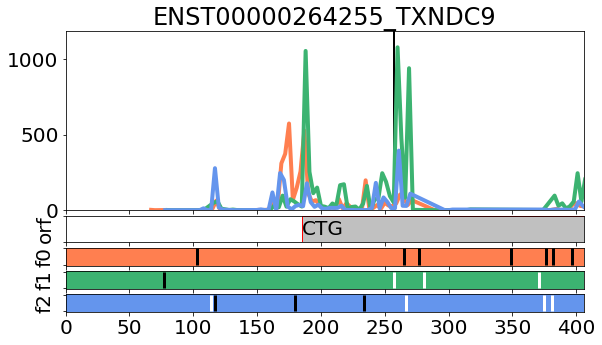

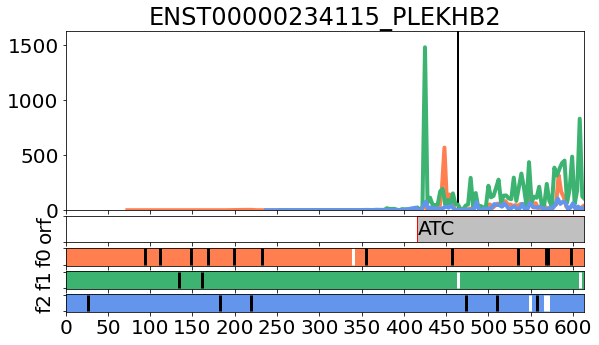

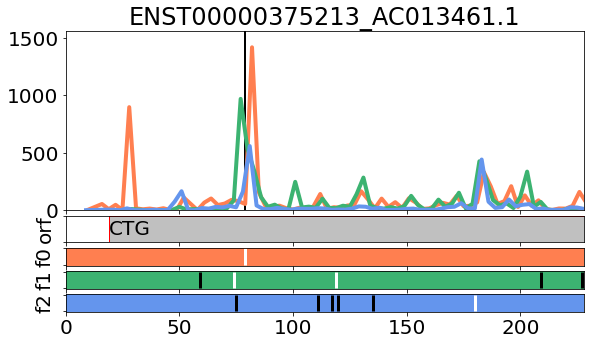

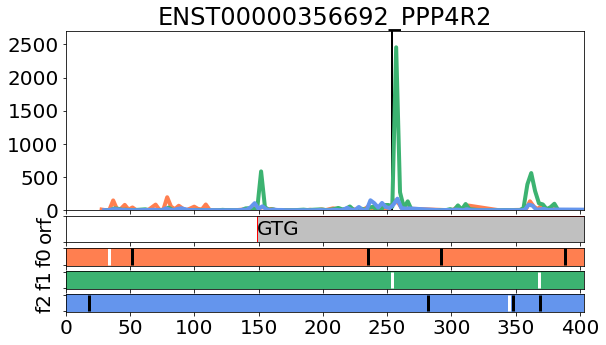

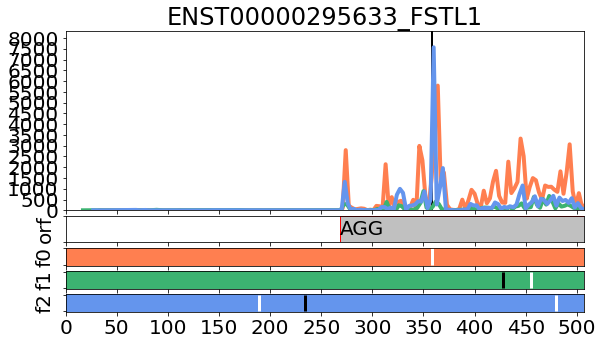

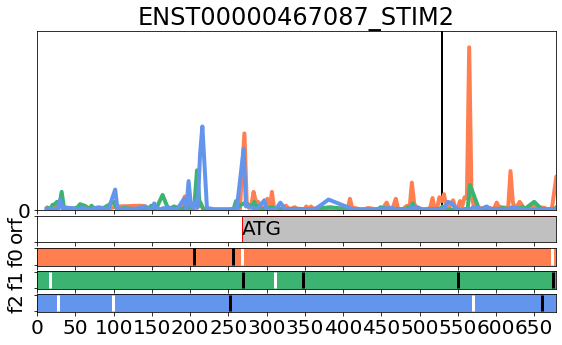

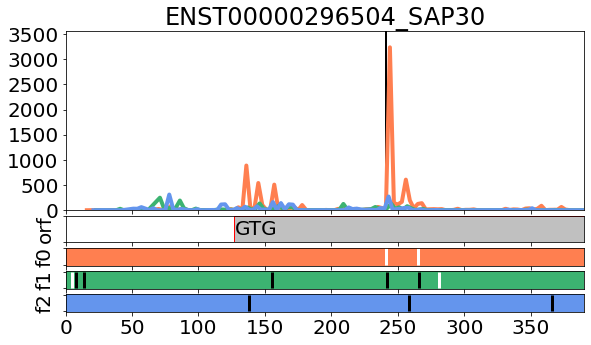

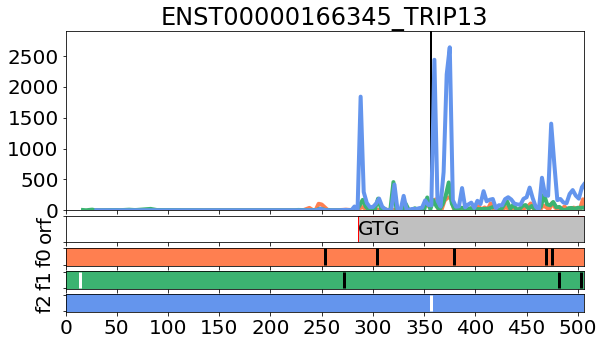

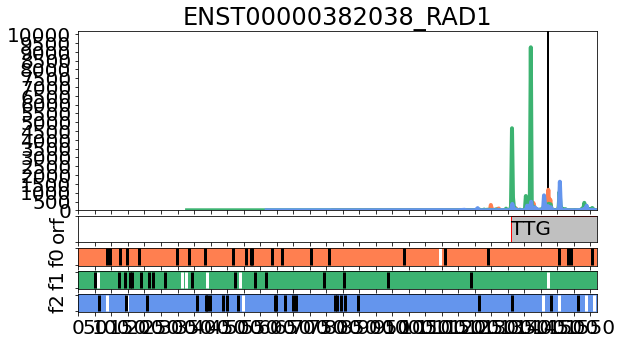

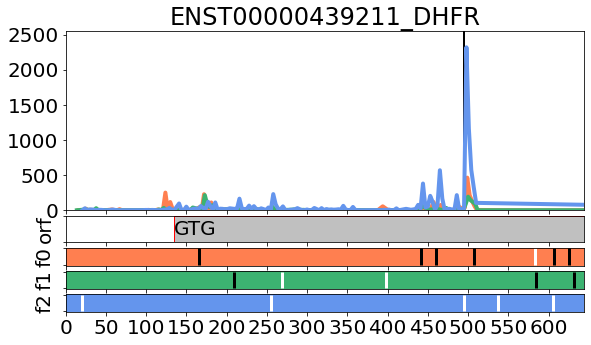

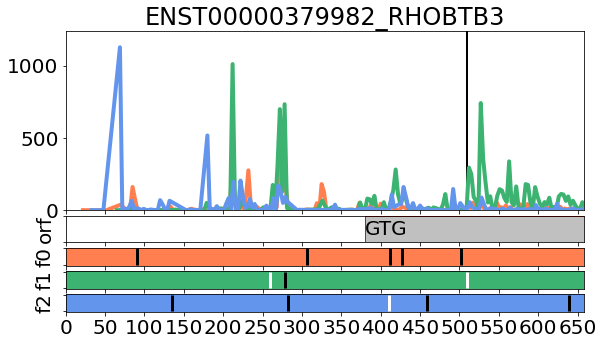

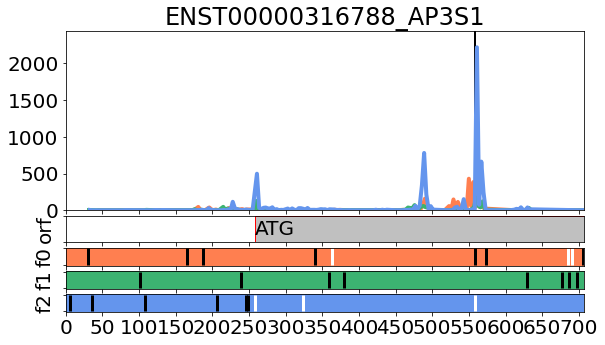

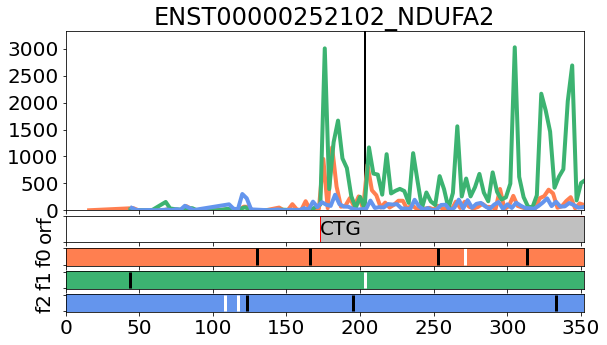

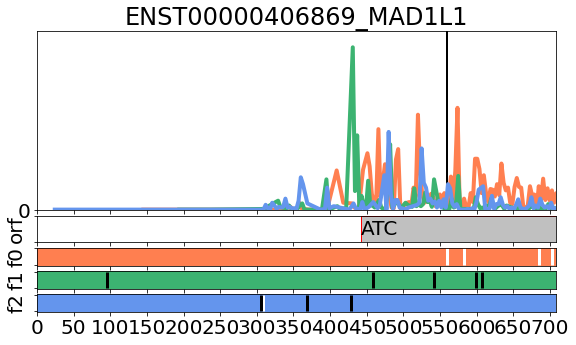

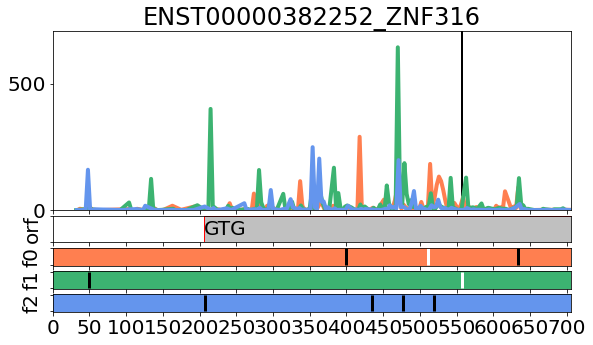

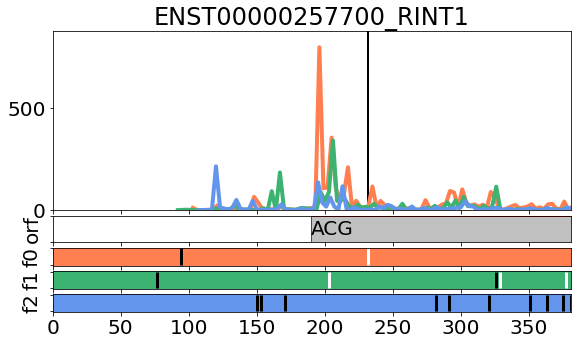

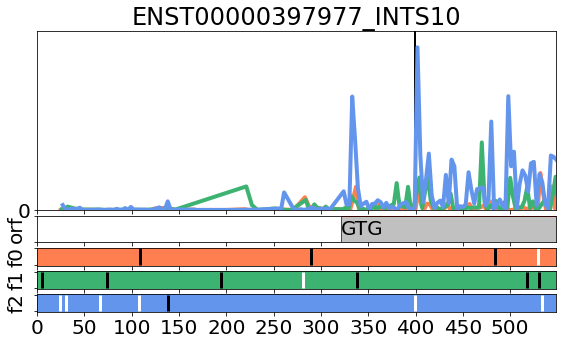

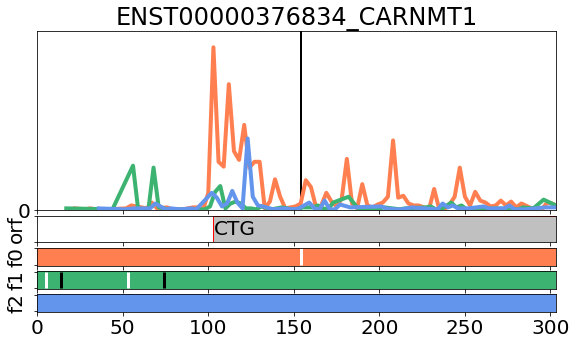

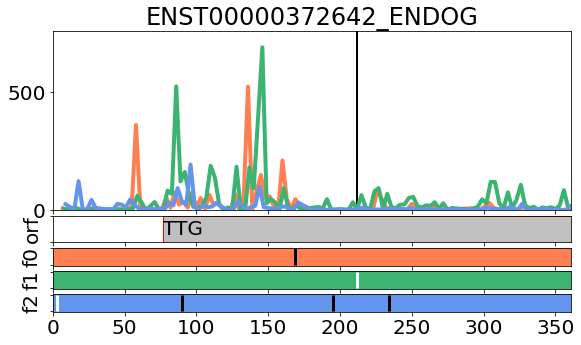

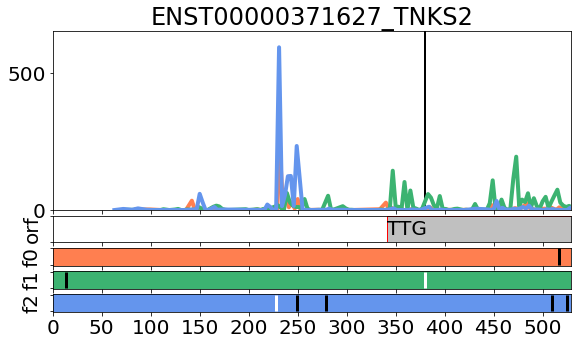

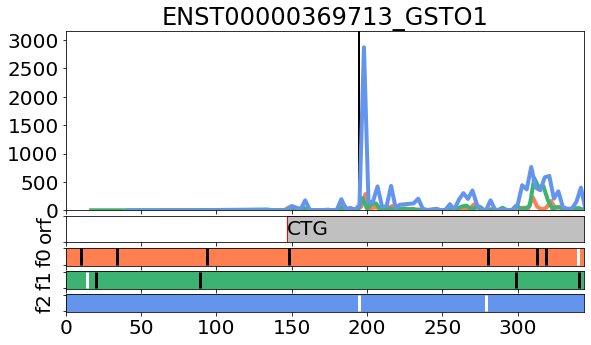

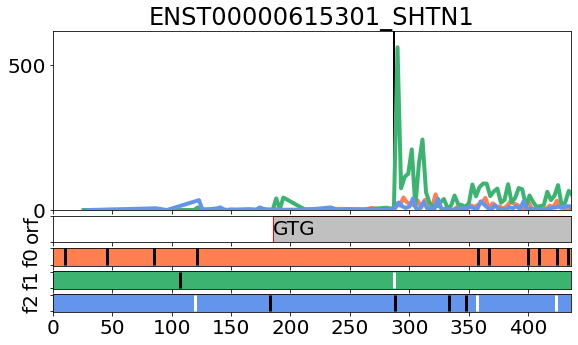

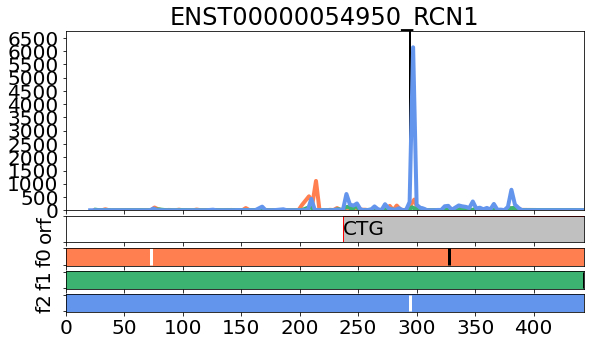

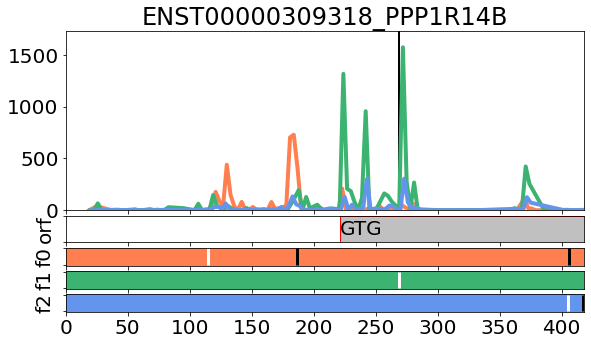

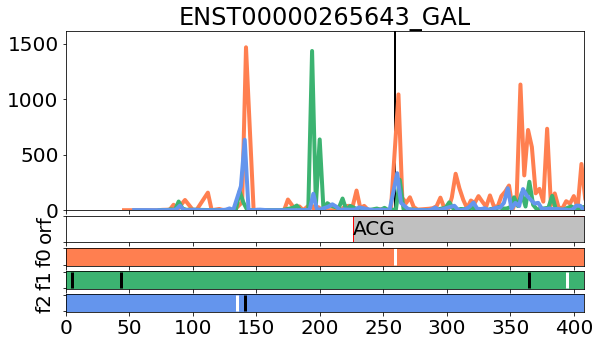

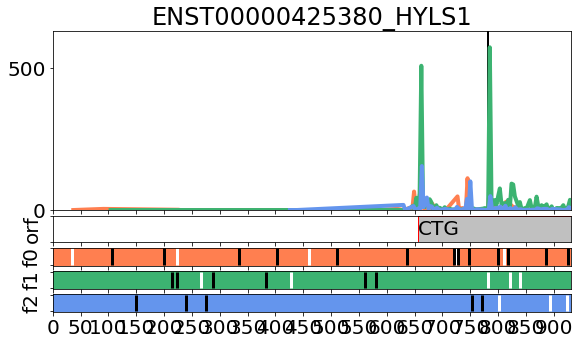

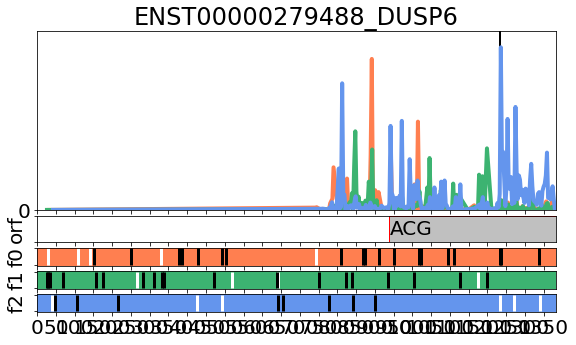

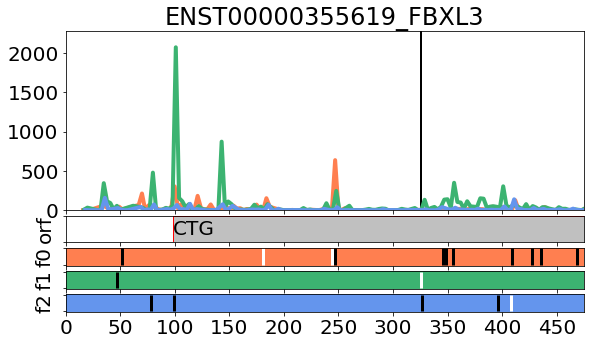

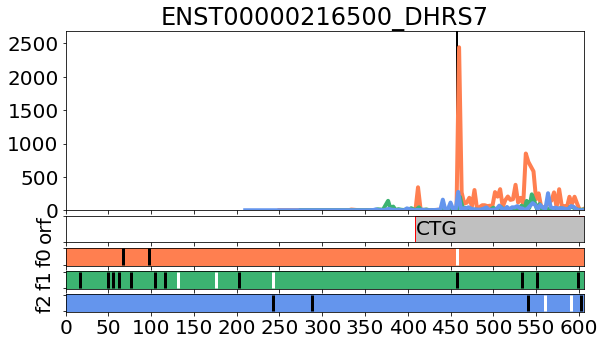

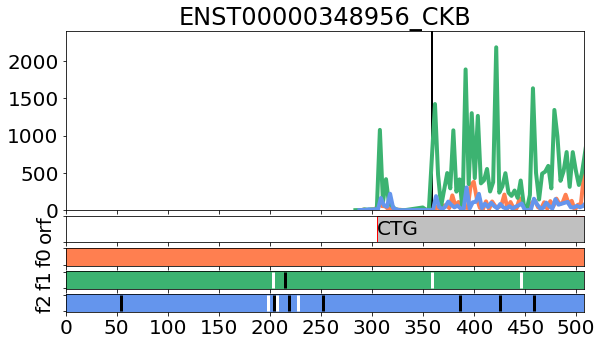

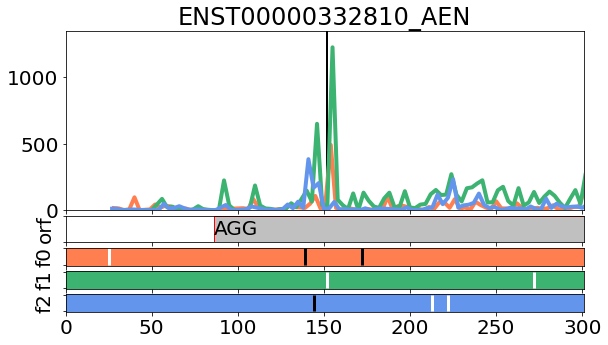

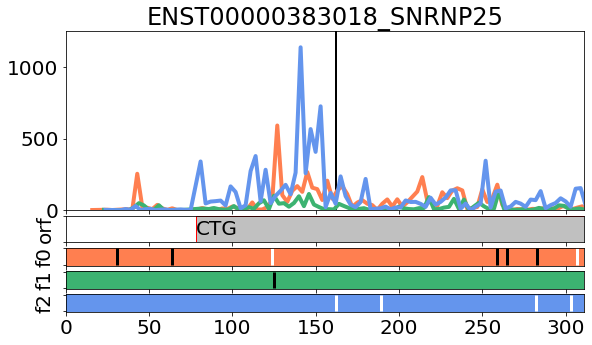

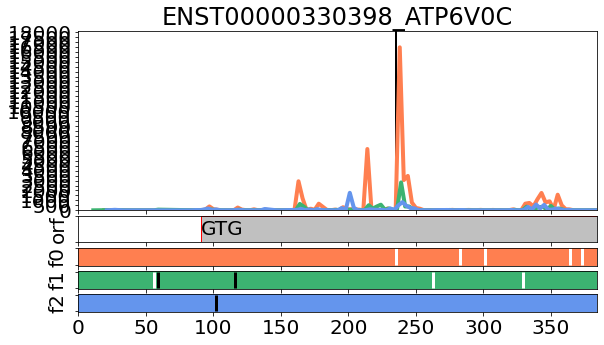

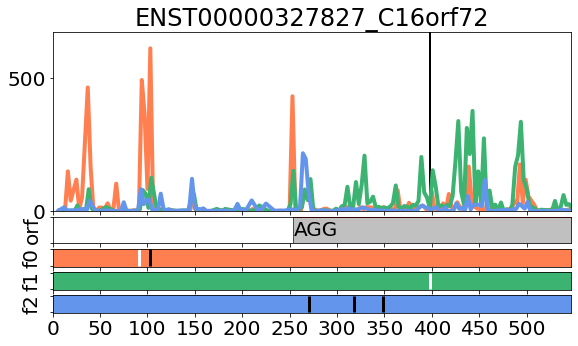

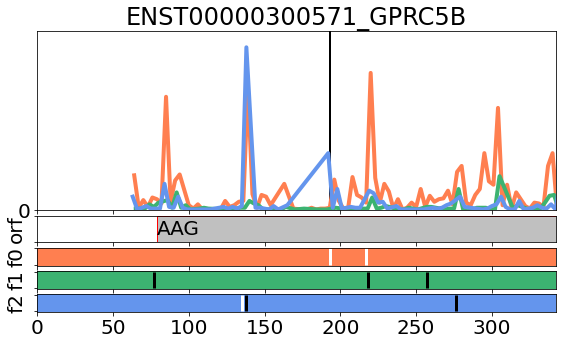

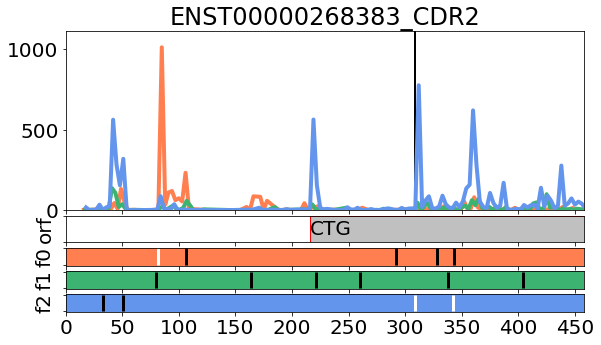

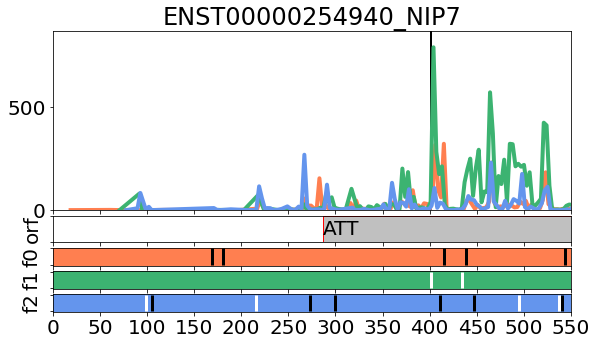

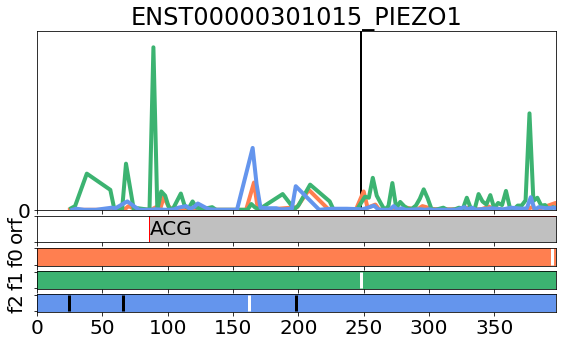

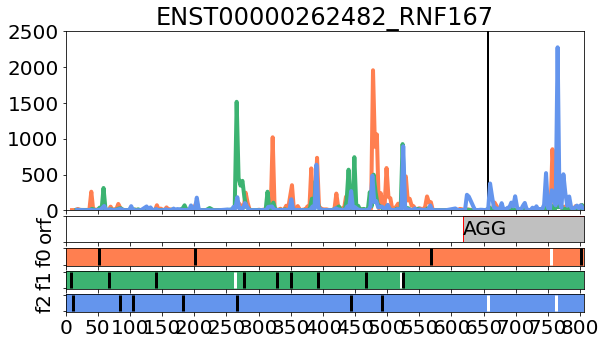

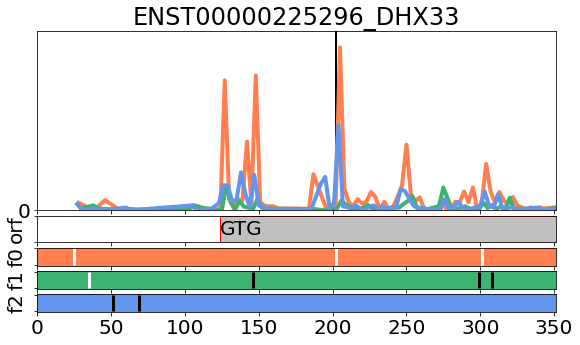

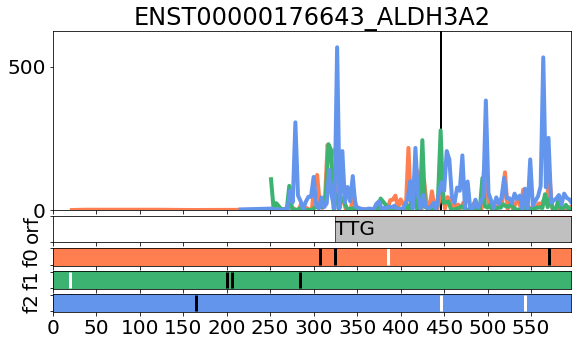

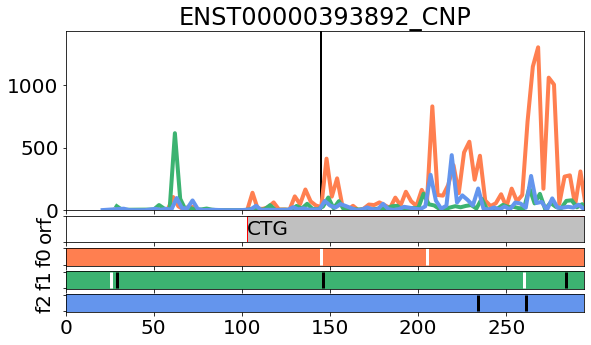

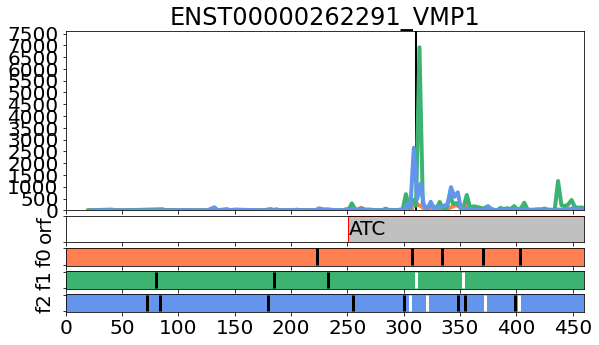

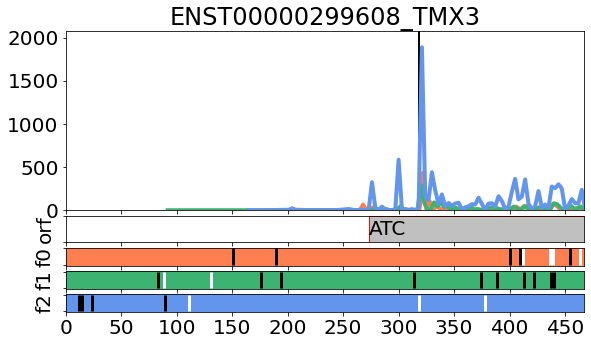

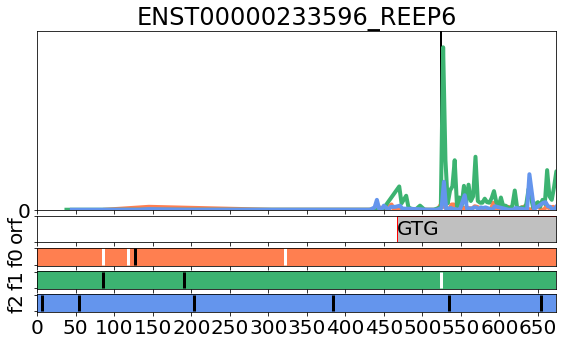

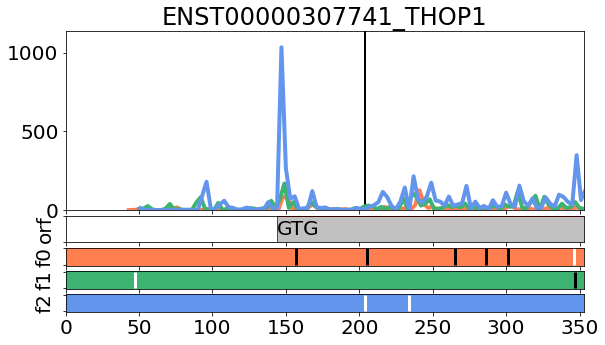

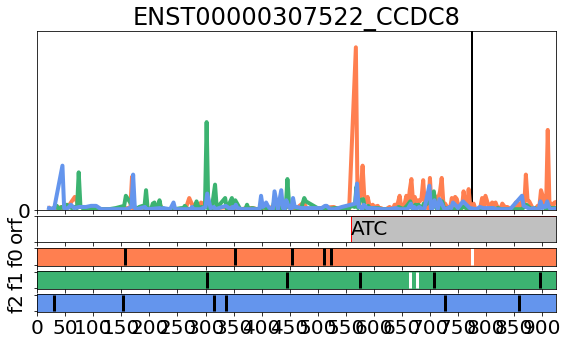

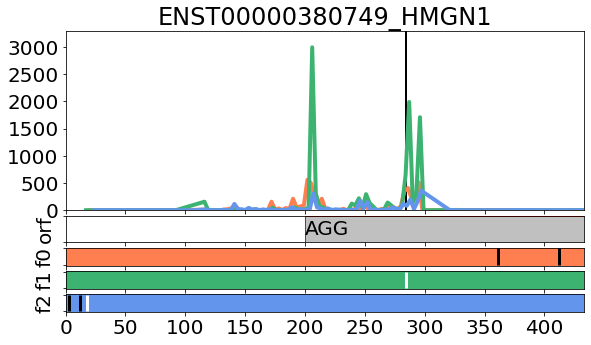

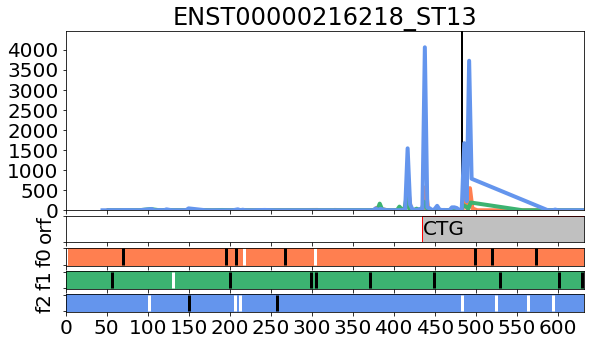

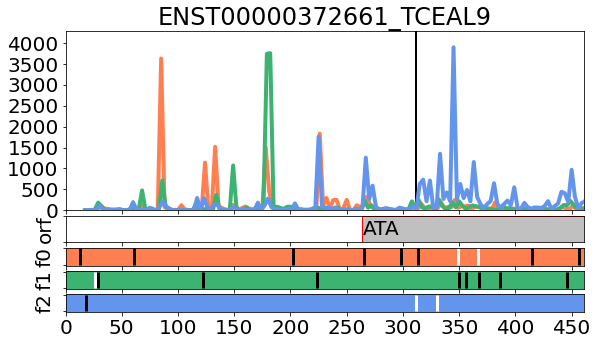

In [20]:
for el in list(out_of_frame_ATGs_Rset_df.gene.unique()):
    gene = el
    tr_id = R_Set[R_Set['gene'] == gene].iloc[0].tr_id.split('.')[0]
    
    pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
    pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


    pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

    xlims = [0, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

    d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =500, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

    trips_full2(d1, name='SFPQ', font1=20, font2=24)

In [ ]:
C16orf72, SNRNP25, PPP1R14B

# -----------------

In [ ]:
gene = 'SNRNP25'
tr_id = R_Set[R_Set['gene'] == gene].iloc[0].tr_id.split('.')[0]
    
pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='test', font1=20, font2=24)

# SNRNP25

1138
0


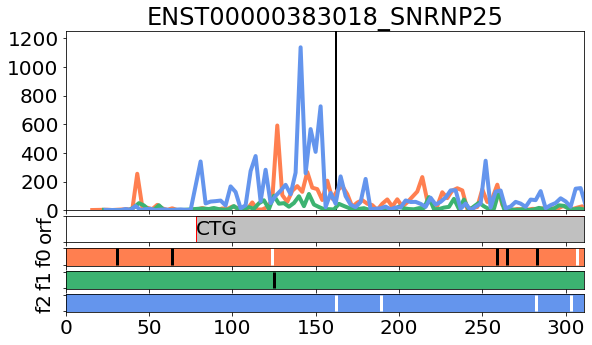

In [56]:
gene = 'SNRNP25'
tr_id = R_Set[R_Set['gene'] == gene].iloc[0].tr_id.split('.')[0]
    
pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='test', font1=20, font2=24)

# CDR2

1013
0


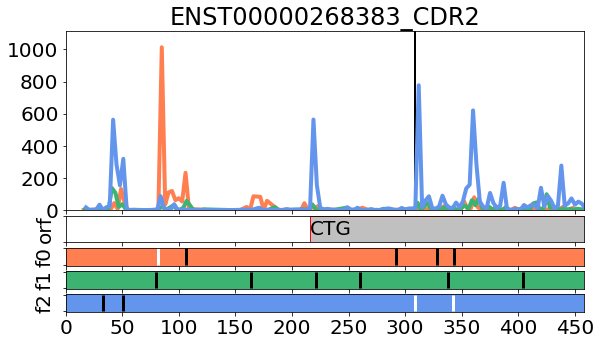

In [55]:
gene = 'CDR2'
tr_id = R_Set[R_Set['gene'] == gene].iloc[0].tr_id.split('.')[0]
    
pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='test', font1=20, font2=24)

# FAM102B

493
0


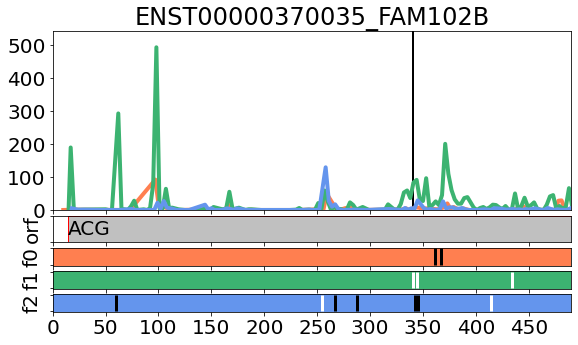

In [49]:
gene = 'FAM102B'
tr_id = R_Set[R_Set['gene'] == gene].iloc[0].tr_id.split('.')[0]
    
pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='test', font1=20, font2=24)

In [48]:
file_counts = pd.read_csv('data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id))
file_counts.at[15, 'Frame 2'] = 1

file_counts.drop('Unnamed: 0', axis=1).to_csv('data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), index=False)

# RNF167

2279
0


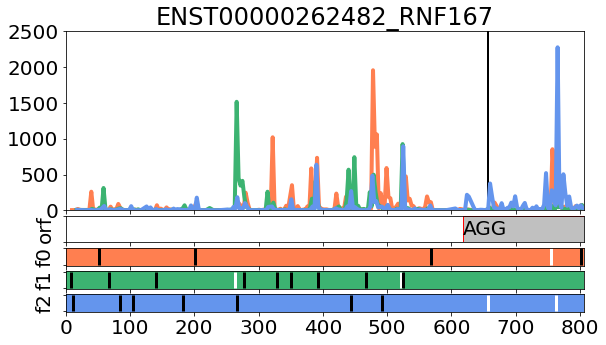

In [52]:
gene = 'RNF167'
tr_id = R_Set[R_Set['gene'] == gene].iloc[0].tr_id.split('.')[0]
    
pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =500, 
                             fraq = 100, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='test', font1=20, font2=24)

# PIEZO1

311
0


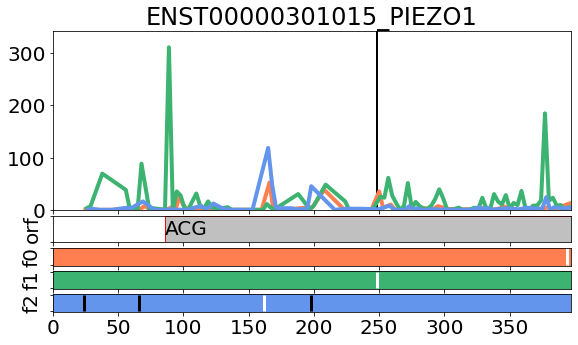

In [53]:
gene = 'PIEZO1'
tr_id = R_Set[R_Set['gene'] == gene].iloc[0].tr_id.split('.')[0]
    
pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [0, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='test', font1=20, font2=24)

In [ ]:
DHRS7 - 2 non-ovlp uORFs and 1 is ovlp CDS uORF - no translation present 
SMIM12 - ovlp uORF no tr
BTF3L4 - non-ovlp uORF no
* PCSK9 - non-pvlp uORF translated before the start of ext 
* FAM102B - non ovelp uORF is translated  do not seem to interfere
** EPRS uORF overlaps with pred NTE do not seem to be actively translated (a bit)
* DESI2 non ovlp uORF tr
ID2 no transl
* TXNDC9 non ovlp uORF 
PLEKHB2
** AC013461.1 ovlp UORF has init peak 
* PPP4R2 non ovlp uORF 
FSTL1
STIM2 ATG extension ovlp uORF is no tr
SAP30
TRIP13
* RAD1 might be ovlp uORF 
DHFR
* RHOBTB3 might be ovlp uORF 
AP3S1
* NDUFA2 non-ovlp uORF tr
* MAD1L1 upstream uORFs 
* ZNF316 ovlp uORFs 
* RINT1 ovlp UORF
** INTS10 might non ovlp uORF and ovlp uORF 
* CARNMT1 non ovlp uORF
* ENDOG ovlp uORF 
* TNKS2 non ovlp uORF 
GSTO1
SHTN1
RCN1
* PPP1R14B non-ovlp uORF 
* GAL non ovlp uORF 
HYLS1
* DUSP6 might be ovlp uORF 
* FBXL3 ovlp uORF 
CKB
AEN
* SNRNP25 might be ovlp with CDS uORF 
ATP6V0C
* C16orf72 non ovlp 
* GPRC5B ovlp 
* CDR2 non ovlp
* NIP7 non ovlp 
* PIEZO1 ovlp
RNF167
DHX33
* ALDH3A2 might be ovlp with UORF 
CNP
* VMP1 ovlp uORF 
TMX3
REEP6
THOP1
CCDC8
HMGN1
ST13
TCEAL9